In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
!unzip drive/MyDrive/Datasets/X-Ray_Validation_Dataset.zip
clear_output()

In [4]:
INPUT_SHAPE = 160
BATCH_SIZE = 64

In [5]:
generator = ImageDataGenerator(rescale=1./255)

train_data = generator.flow_from_directory(
    "DATASET/train",
    target_size=(INPUT_SHAPE, INPUT_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True)

validation_data = generator.flow_from_directory(
    "DATASET/val",
    target_size=(INPUT_SHAPE, INPUT_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True)

test_data = generator.flow_from_directory(
    "DATASET/test",
    target_size=(INPUT_SHAPE, INPUT_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True)

Found 6500 images belonging to 2 classes.
Found 1750 images belonging to 2 classes.
Found 1750 images belonging to 2 classes.


In [6]:
train_data.class_indices

{'non xray': 0, 'xray': 1}

In [7]:
model = Sequential([
                    Input(shape=(INPUT_SHAPE, INPUT_SHAPE, 3)),
                    Conv2D(32, (3,3), activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(128, (3,3), activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(256, (3,3), activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Conv2D(512, (3,3), activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Flatten(),
                    Dense(512, activation='relu'),
                    Dropout(0.4),
                    Dense(256, activation='relu'),
                    Dropout(0.4),
                    Dense(1, activation='sigmoid')

])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [8]:
with tf.device("/device:GPU:0"):
  history = model.fit_generator(
      train_data,
      steps_per_epoch = train_data.samples // BATCH_SIZE,
      validation_data = validation_data, 
      validation_steps = validation_data.samples // BATCH_SIZE,
      epochs = 2
      )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/2
101/101 [==============================] - 81s 697ms/step - loss: 0.1874 - accuracy: 0.9417 - val_loss: 0.0214 - val_accuracy: 0.9936
Epoch 2/2
101/101 [==============================] - 69s 681ms/step - loss: 0.0203 - accuracy: 0.9953 - val_loss: 0.0493 - val_accuracy: 0.9896


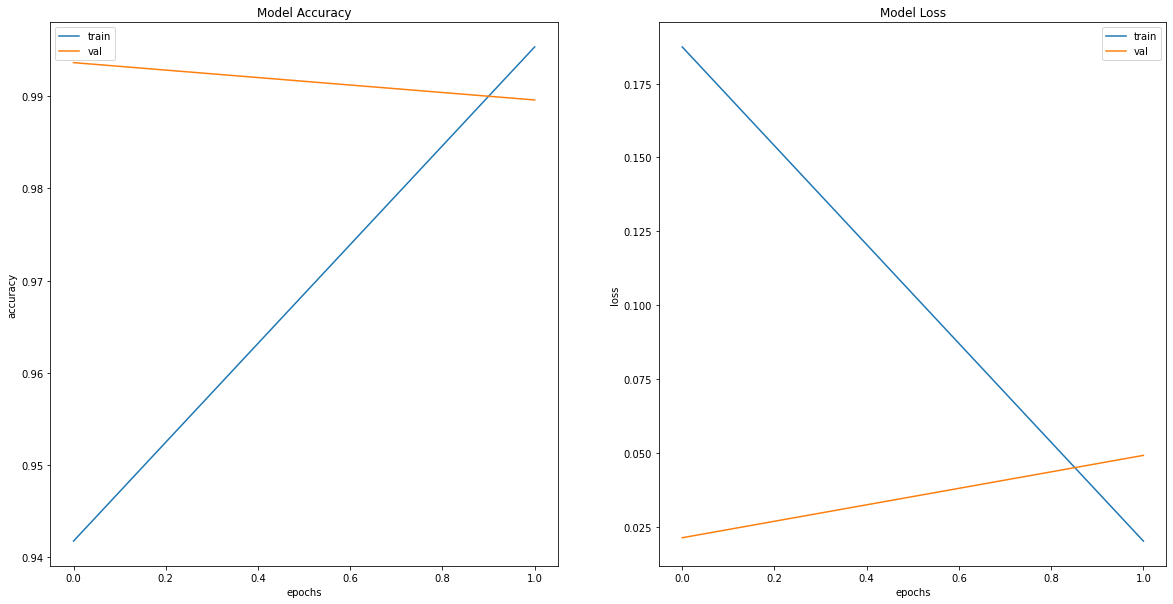

In [9]:
plt.figure(figsize=(20,10))

for i, met in enumerate(['accuracy', 'loss']):
  plt.subplot(1,2,i+1)
  plt.plot(history.history[met])
  plt.plot(history.history["val_"+met])
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

In [10]:
model.evaluate(test_data)

28/28 [==============================] - 16s 569ms/step - loss: 0.0292 - accuracy: 0.9914


[0.029181765392422676, 0.991428554058075]

In [11]:
model.save("validator.h5")

In [12]:
import cv2
import numpy as np

In [16]:
img1 = cv2.resize(cv2.imread("wf.jpeg"),(160,160))/255.
img2 = cv2.resize(cv2.imread("bb.jpg"),(160,160))/255.
img3 = cv2.resize(cv2.imread("1.jpg"),(160,160))/255.
img4 = cv2.resize(cv2.imread("2.png"),(160,160))/255.
img5 = cv2.resize(cv2.imread("3.jpg"),(160,160))/255.

In [17]:
x=np.array([img1,img2,img3,img4,img5])
x.shape

(5, 160, 160, 3)

In [18]:
pred = model.predict(x)
y_classes = ((pred > 0.5)+0).ravel()
print(pred)
y_classes

[[0.17034765]
 [0.23272619]
 [0.9988024 ]
 [0.99990916]
 [0.9999356 ]]


array([0, 0, 1, 1, 1])

In [19]:
!cp validator.h5 drive/MyDrive/Covid-Pneumonia_Detection_Model/xray_validator_v2.h5